# Data Mining Final Project: People Analytics - IBM HR Dataset

## Script Overview: 

### Abstract
+ **Project goals**: 
  - Apply data mining mthods on fictitious IBM employee data to derive answers to the following questions:
    - Which employees are likely to leave?
    - Answer the question of how we might specifically retain top performers (i.e. Is there anything unique about them? Can we capture that extra cost in our model?)
    - Understand which employees are leaving, in terms of characteristics and experiences
    - Predict which current employees are at risk of leaving
    - Determine which levers the company can use to reduce attrition going forward (particularly for top performers)
+ **Description of data**: 
  - 34 numerical and categorical features of employees and a single column that indicates whether or not they have left the company (attrition)
+ **Variable definitions**:
  - https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/discussion/86957
+ **Assumptions**:
  - The dataset provides a picture of an entire organization at multiple management levels
  - Attrition metric accounts only for people leaving voluntarily (e.g. retirement, switching companies)
+ **Methods**:
  - EDA, Pipelines, Feature engineering, Ensemble learning, PCA and Dimensionality reduction (t-SNE), Hierarchical clustering, Classification, Logistic regression, Random forest, Gradient boosting, Regression, PCA, agglomerative clustering, t-SNE, Model evaluation (TODO extrapolate?), Loss function
+ **Limitations and risks**: 
  - Need to be very careful when using HR data. If not careful, may make illegal decisions related to employment law or using health data. Important to work with HR compliance/HR Legal. For that reason, should NOT be used for firing decisions. Should be used for internal employee experience improvement primarily.
+ **Summary of conclusions**: 
  - TODO
    - Which employees are likely to leave?
    - Answer the question of how we might specifically retain top performers (i.e. Is there anything unique about them? Can we capture that extra cost in our model?)
    - Understand which employees are leaving, in terms of characteristics and experiences
    - Predict which current employees are at risk of leaving
    - Determine which levers the company can use to reduce attrition going forward (particularly for top performers)


### Table of Contents
+ **Step 1**: Environment set-up and data load
+ **Step 2**: Exploratory data analysis (EDA) and data processing
+ **Step 3**: Dimensionality reduction
+ **Step 4**: Clustering
+ **Step 5**: Linear classification models
+ **Step 6**: Non-linear classification models
+ **Step 7**: Graph anaylsis (???)

## Step 1: Environment set-up and data load

In [65]:
# Data processing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import stats
from numpy import mean
from numpy import std

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from pandas.plotting import scatter_matrix

# Model functions
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold



# Ignore Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df  = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Step 2: EDA and data processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
# Getting a sense of how many categories we're dealing with
print(df['Attrition'].unique())
print(df['BusinessTravel'].unique())
print(df['Department'].unique())
print(df['EducationField'].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']


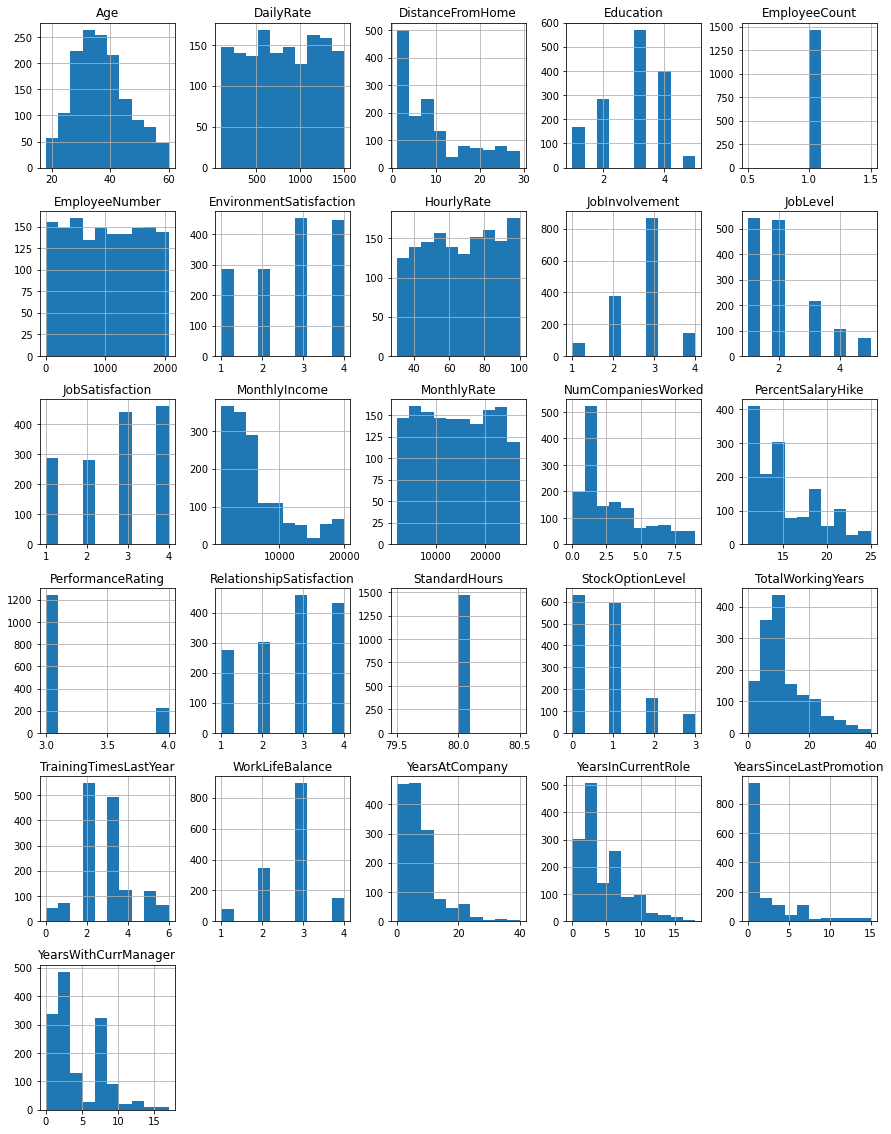

In [5]:
# Plotting distributions
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
df.hist(ax = ax)
pass # Added to hide the plot messages

# Imbalanced training set we''ll need to address (1200 still there, 200 attritioned)
# Most employees are close to the office (within 10 miles)

# Education, Environment Satisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, 
# RelationshipSatisfaction, WorkLifeBalance should also probably be treated as categorical 

In [6]:
#TODO plot attrition by subgroups --> consider adding attrition into corr plot

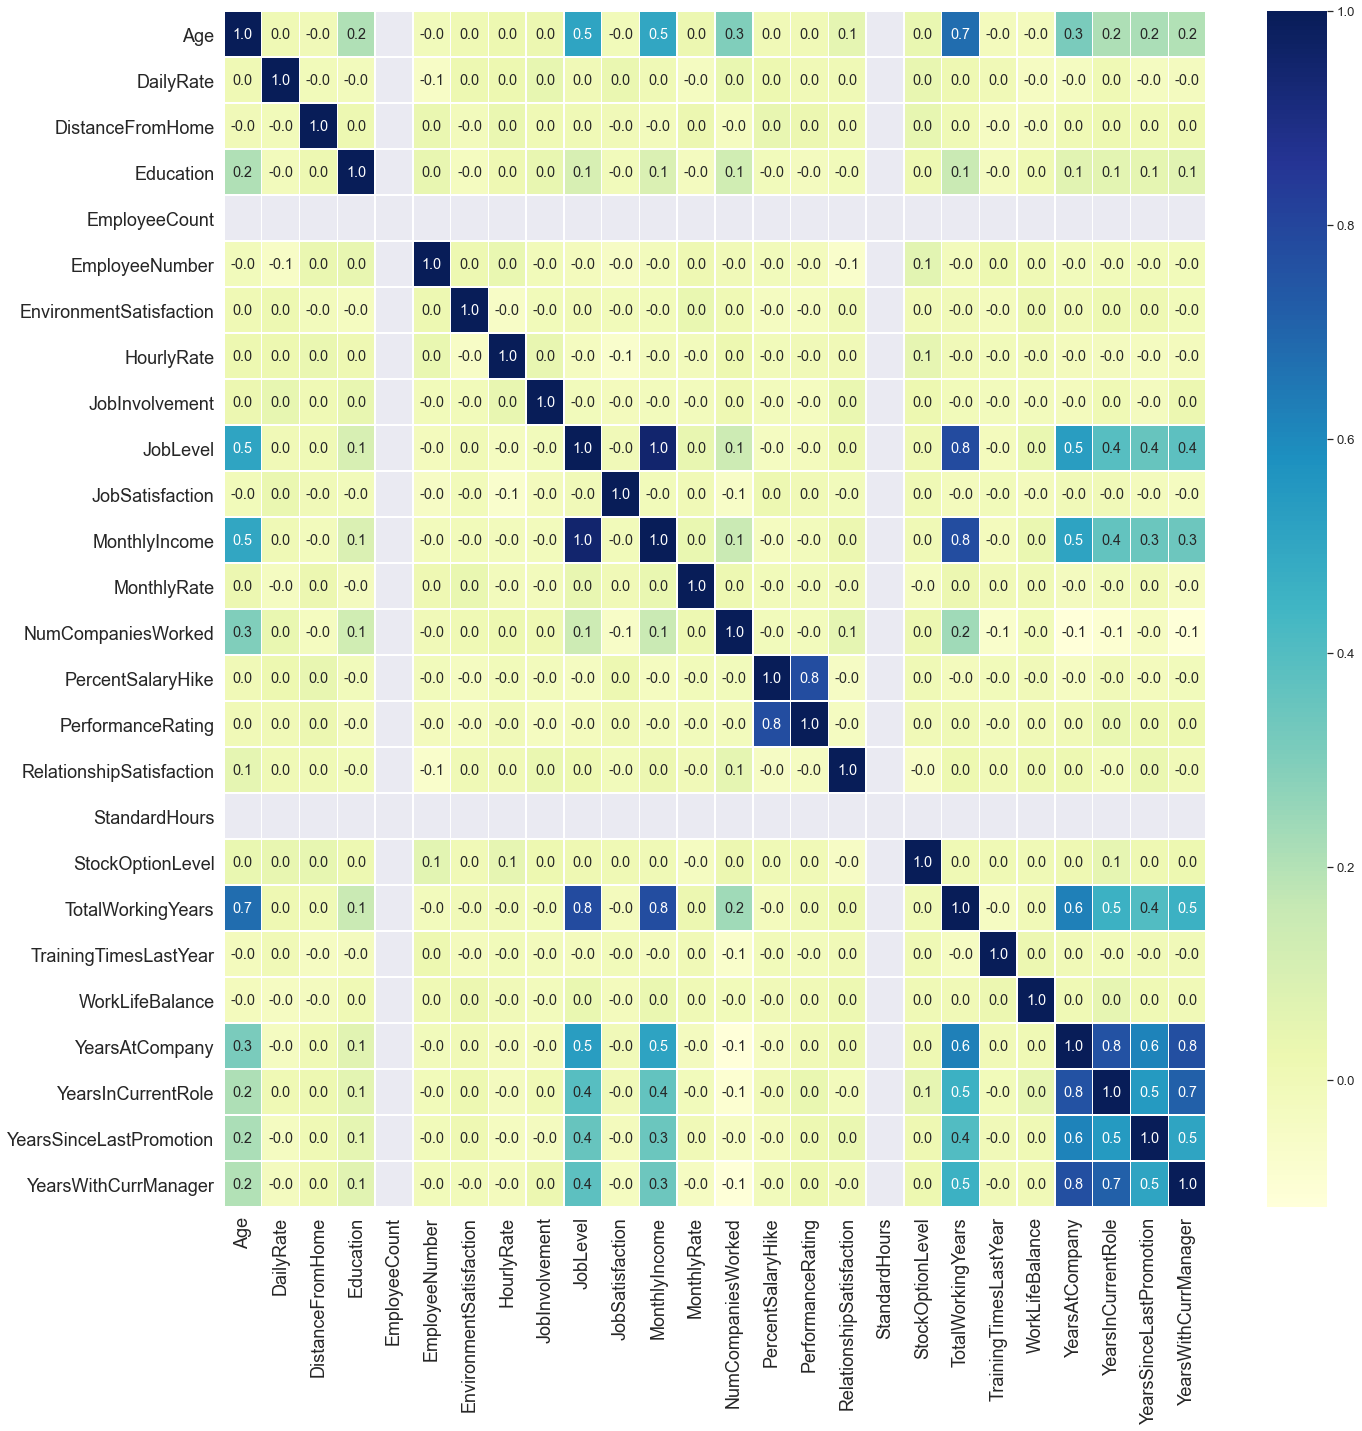

In [7]:
# Heatmap of correlations
# Low correlation for most fields, dispelling some concerns about multicollinearity. Should be able to use all predictors
sns.set(font_scale=1.2)# Increase font size of corr values

f,ax = plt.subplots(figsize=(22, 22))
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="YlGnBu")
pass

In [8]:
# Using a scatter matrix to visualize correlations
# TODO - if using, need to select only first 30 or so features since new features are not at all correlated
# pd.plotting.scatter_matrix(df, figsize=(15, 15))
# fig=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
# plt.show()

In [9]:
# Create a label encoder object
le = LabelEncoder()

In [10]:
plt.rcParams['figure.figsize'] = (18,18)
print('Size of initial unencoded dataset (categorical columns intact): {}'. format(df.shape))
df.head()

Size of initial unencoded dataset (categorical columns intact): (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [11]:
# Label Encoding will be used for columns with 2 or less unique values - creates new binary columns for their unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [12]:
# convert rest of categorical variable into dummy
df = pd.get_dummies(df, drop_first=True)
print('Size of Full Encoded Dataset (new binary columns created): {}'. format(df.shape))
df.head()
# df.info()

Size of Full Encoded Dataset (new binary columns created): (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [13]:
# Creating our target dataframe
target = df['Attrition'].copy()

# Drpoping attrition
print('Size of Full dataset is: {}'.format(df.shape))
df.head()
# A lot of kernels suggest also dropping these 'redundant' features. #TODO Look into why these are considered redundant
# df['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'']

Size of Full dataset is: (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [14]:
np.save('data/attrition_data_transformed', df)

In [15]:
# Now is where we'll address the fact that our dataset is not balanced regarding the number of attrition versus non-attrition (data imbalance)
# Stratify helps maintain a ratio in the training set

# IMPORT
reduced = np.load('data/attrition_data_transformed.npy')


# -------------------- COPY AND PASTE THE CODE BELOW FOR YOUR TEST/TRAIN --------------------
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1102, 49)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 49)
Number transactions y_test dataset:  (368,)


## Step 3: Dimensionality reduction

## Step 4: Clustering

## Step 5: Linear classification models

#### Decision Trees

In [16]:
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# For reference: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [17]:
dfValues=X_train.values
normalized_dfValues = preprocessing.normalize(dfValues)
plt.figure(figsize=(15,12))

# Calculate the linkage: mergings
mergings = linkage(normalized_dfValues, method='ward')

# generate the linkage matrix
Z = linkage(normalized_dfValues, 'ward')

<Figure size 1080x864 with 0 Axes>

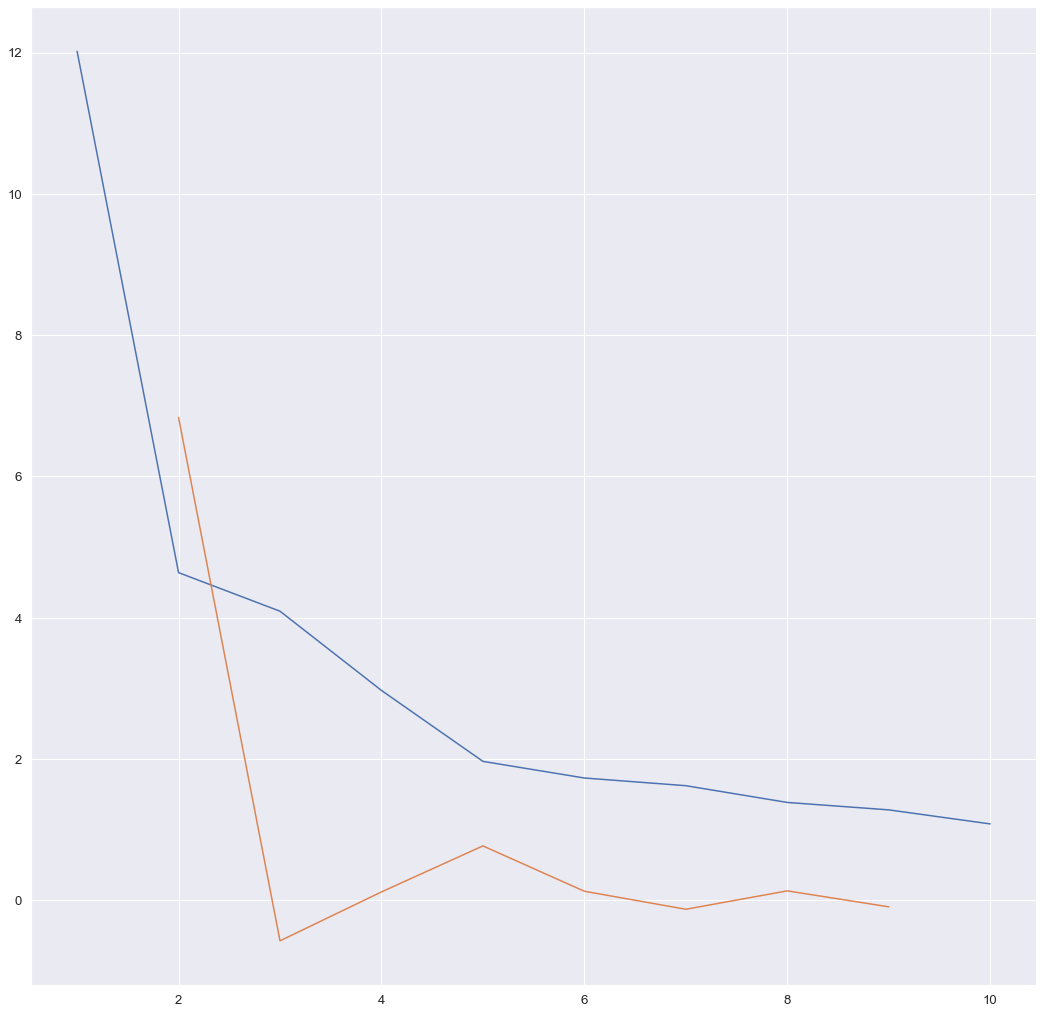

clusters: 2


In [18]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# Interpretation: The "strongest elbow" of the blue line graph below, is the highest value of the orange graph below

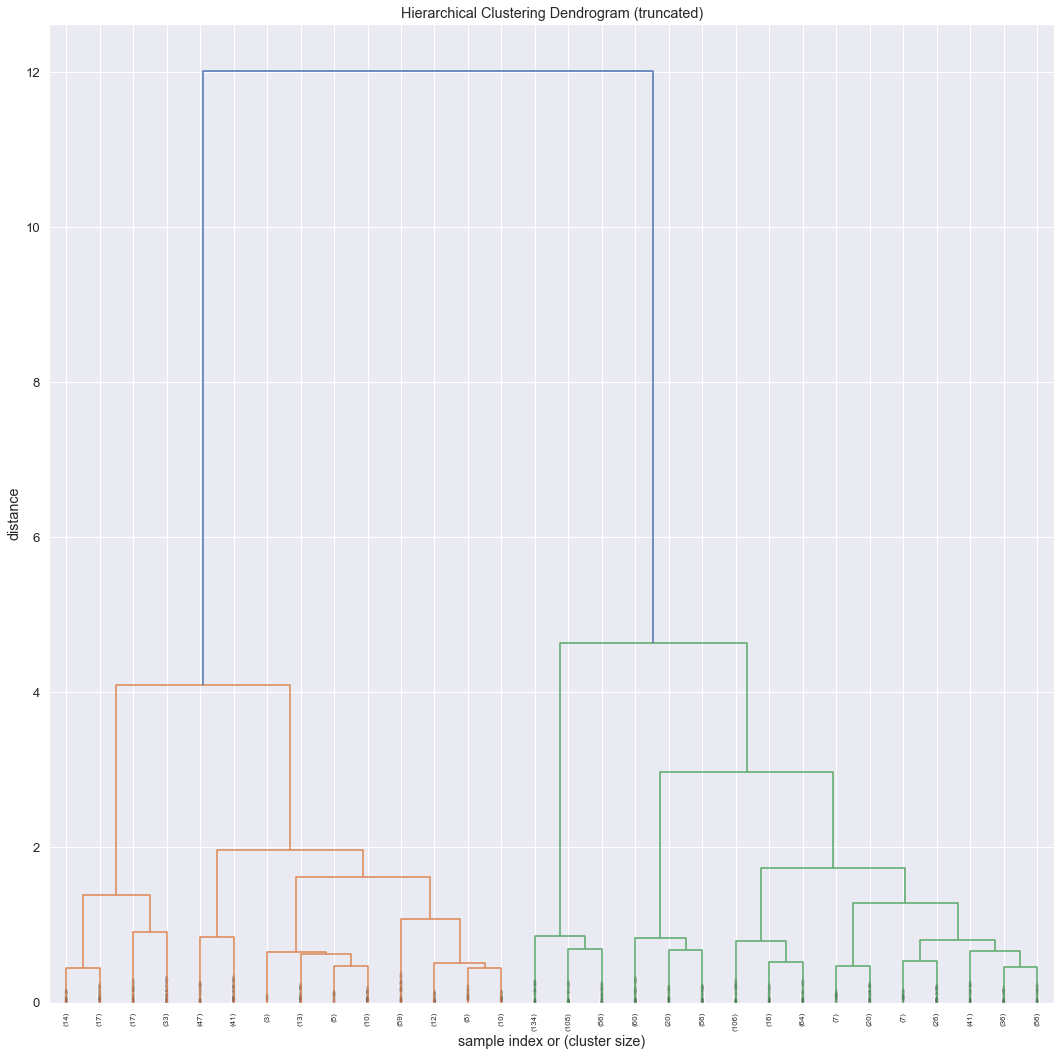

<Figure size 864x720 with 0 Axes>

In [29]:
labels = fcluster(mergings, 70, criterion='distance')

# Plot the dendrogram
dendrogram(
    mergings,
    show_contracted=True,
    truncate_mode='lastp',
    #labels=labels,
    leaf_rotation=90.,
    leaf_font_size = 8
)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.figure(figsize=(12,10))
plt.show()

In [30]:
k=2 # Identified that we have two main clusters above
clusterIDs = fcluster(Z, k, criterion='maxclust') # Create our cluster ids
clusteredTrainXData = pd.DataFrame(dfValues, columns=X_train.columns)
clusteredTrainXData["Cluster"] = clusterIDs # Create new column for clusters
clusteredTrainXData.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Cluster
0,36,0,1174,3,4,1,1425,1,0,99,...,0,0,0,0,0,1,0,0,1,2
1,21,0,546,5,1,1,1623,3,1,97,...,0,0,0,0,1,0,0,0,1,2
2,43,0,422,1,3,1,902,4,0,33,...,0,0,0,0,0,0,0,1,0,2
3,42,0,188,29,3,1,1148,2,1,56,...,1,0,0,0,0,0,0,0,1,2
4,35,0,992,1,3,1,1564,4,1,68,...,1,0,0,0,0,0,0,0,1,2


#### Finally, lets evaluate the accuracy and precision of our hierarchical clustering model

In [98]:
# TODO - evaluation methods .... precision, accuracy, density?
# TODO - what do we know about the people in these clusters? 
#      - How do we do this? Plot the mean delta between each cluster's features?

#### Applying t-SNE to visualize our high dimensional data

It appears we have two main clusters, so I'll now extract the cluster value for each and add it back to a dataframe

In [31]:
# For simplicity of code re-use, I'm moving my cluster column to be the first column in the df
cols = list(clusteredTrainXData.columns)
cols = [cols[-1]] + cols[:-1]
clusteredTrainXData = clusteredTrainXData[cols]
clusteredTrainXData.head()

,Cluster,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,2,36,0,1174,3,4,1,1425,1,0,...,0,0,0,0,0,0,1,0,0,1
1,2,21,0,546,5,1,1,1623,3,1,...,0,0,0,0,0,1,0,0,0,1
2,2,43,0,422,1,3,1,902,4,0,...,0,0,0,0,0,0,0,0,1,0
3,2,42,0,188,29,3,1,1148,2,1,...,0,1,0,0,0,0,0,0,0,1
4,2,35,0,992,1,3,1,1564,4,1,...,0,1,0,0,0,0,0,0,0,1


In [32]:
from sklearn.preprocessing import StandardScaler

tsnedata = clusteredTrainXData
myLabels = tsnedata.iloc[:,0:1]
numericdata = tsnedata.iloc[:,1:-1]
data = StandardScaler().fit_transform(numericdata)
tsnedata.head()
# myLabels.head()
# numericdata.head()
# tsnedata.head()

,Cluster,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,2,36,0,1174,3,4,1,1425,1,0,...,0,0,0,0,0,0,1,0,0,1
1,2,21,0,546,5,1,1,1623,3,1,...,0,0,0,0,0,1,0,0,0,1
2,2,43,0,422,1,3,1,902,4,0,...,0,0,0,0,0,0,0,0,1,0
3,2,42,0,188,29,3,1,1148,2,1,...,0,1,0,0,0,0,0,0,0,1
4,2,35,0,992,1,3,1,1564,4,1,...,0,1,0,0,0,0,0,0,0,1


In [33]:
types=myLabels['Cluster'].astype('category').cat.codes

t-SNE doesn't give me much confidence in my hierarchical clustering model... By color coding our different clusters from the hierarchical model in the t-SNE representation of all our data flattened and clustered, there seems to be a lot of cross pollination...

# TODO TALK ABOUT THIS AS A GROUP

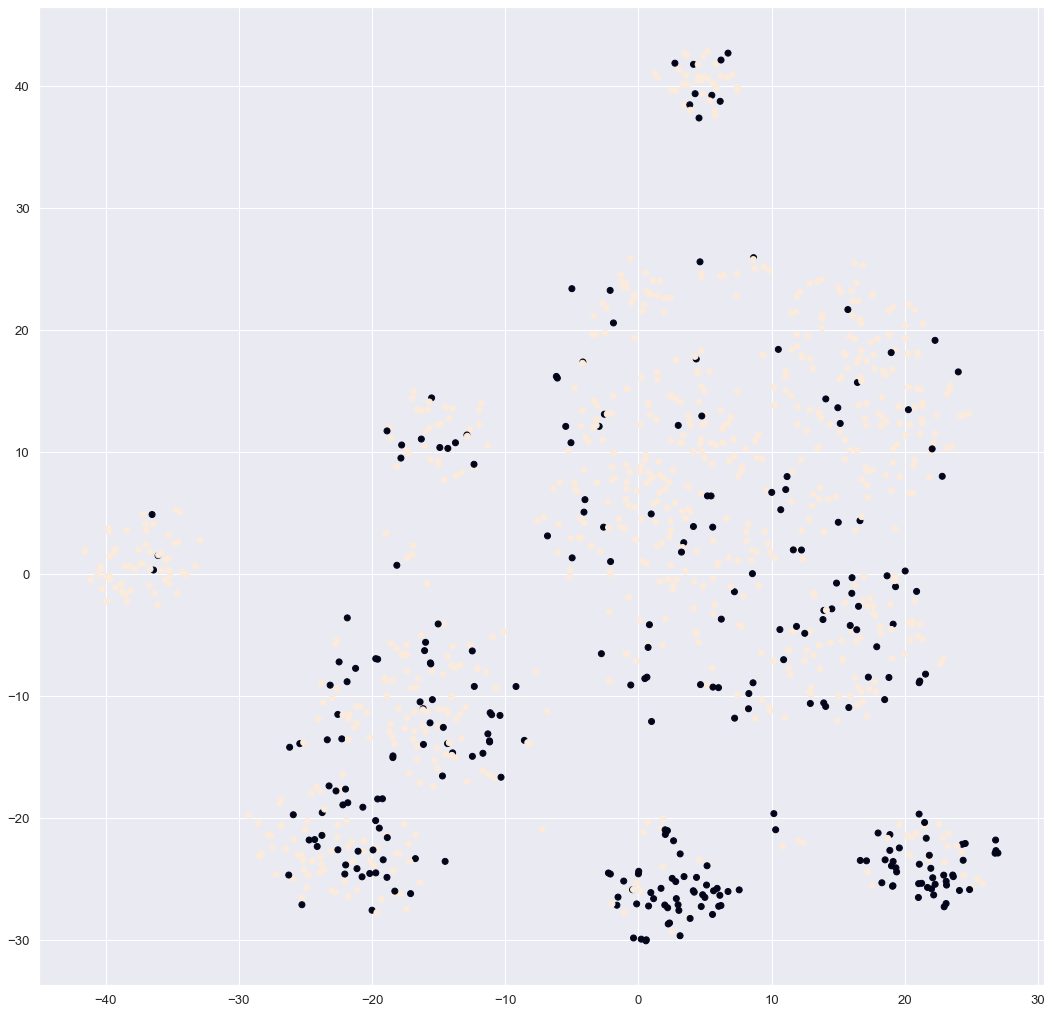

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
model=TSNE(learning_rate=10)

Tsne_transformed=model.fit_transform(data)

xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
plt.scatter(xs,ys, c=types)
plt.show()

#### SVM

In [35]:
from sklearn.svm import LinearSVC

In [36]:
model_svc = LinearSVC()

model_svc.fit(X_train, y_train)

#Gonna need some way to figure out the balance issue here
y_pred = model_svc.predict(X_test)

In [37]:
acc_svc = round(model_svc.score(X_test, y_test)*100, 2)
print(str(acc_svc) + ' percent')

83.97 percent


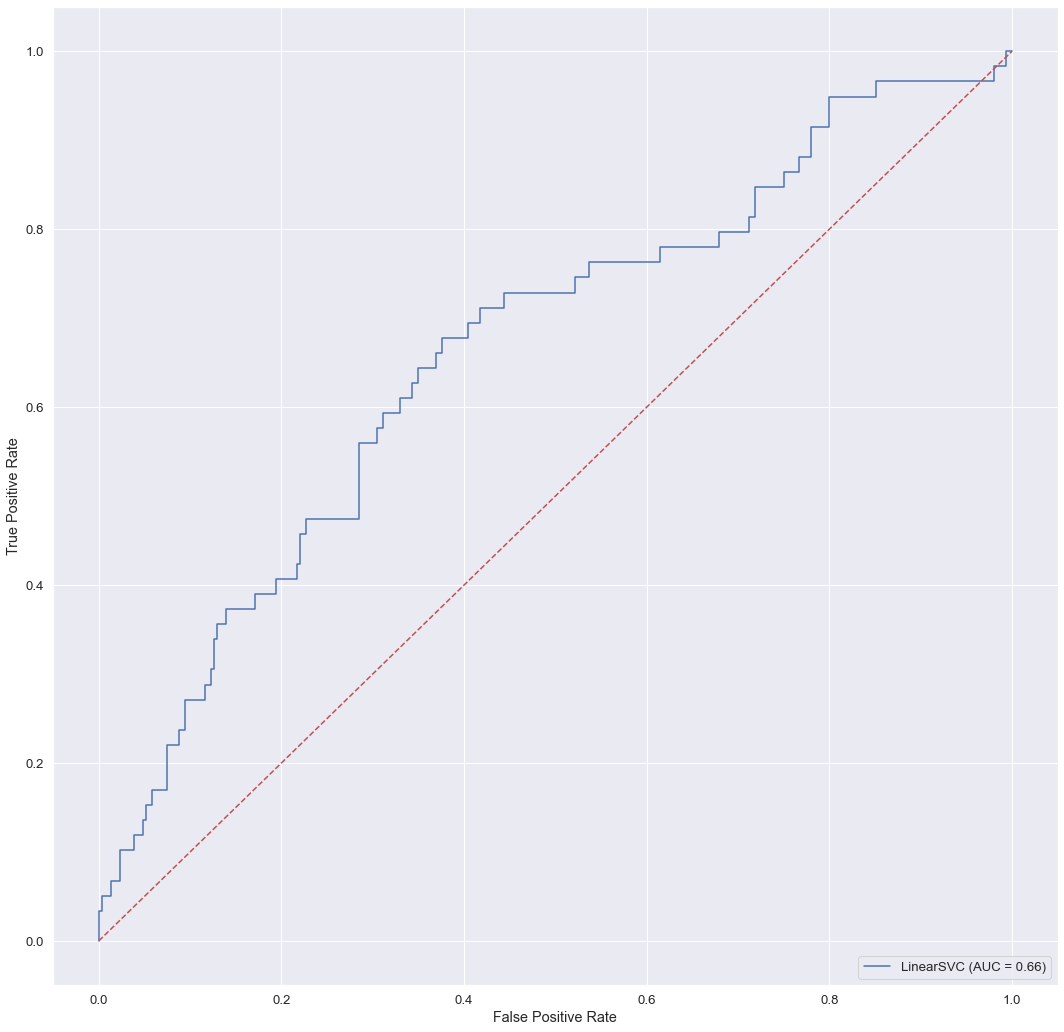

In [38]:
metrics.plot_roc_curve(model_svc, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

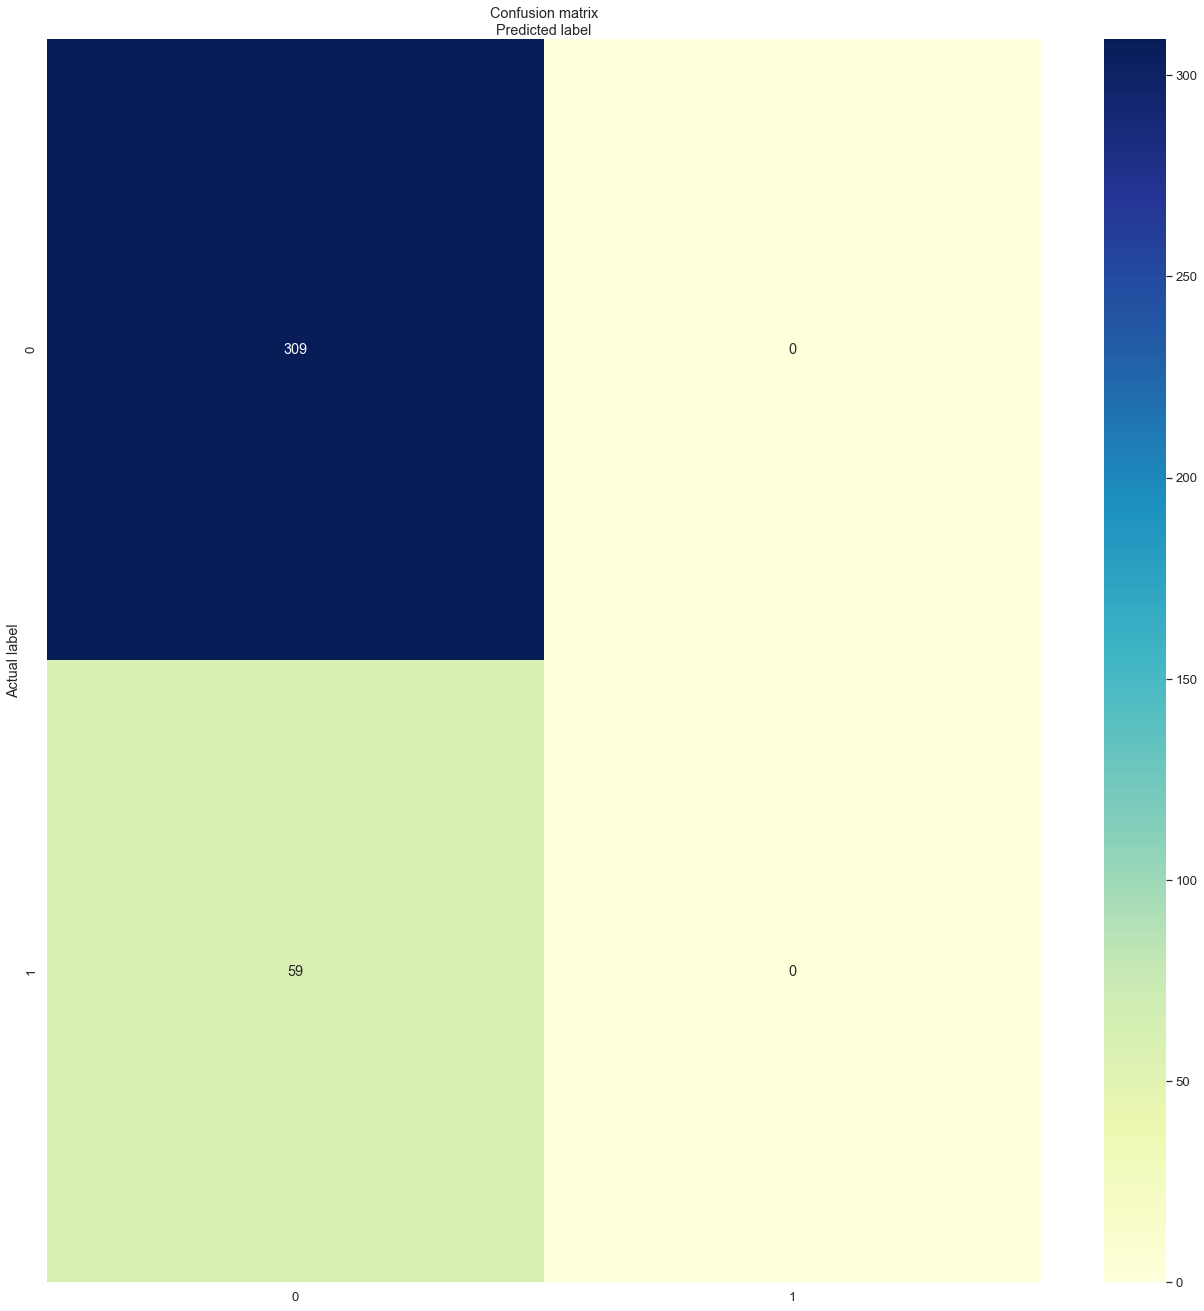

In [39]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Logisitic Regression

In [40]:
import statsmodels.api as sm
from scipy import stats

In [41]:
feature_cols = ['Age', 'Education', 'YearsInCurrentRole', 'YearsAtCompany']

X_train_lr = X_train[feature_cols] 
X_test_lr = X_test[feature_cols] 

In [42]:
model_lr_sm = sm.Logit(y_train, X_train_lr).fit()

print(model_lr_sm.summary())

Optimization terminated successfully.
         Current function value: 0.420604
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:                 0.04881
Time:                        09:43:49   Log-Likelihood:                -463.51
converged:                       True   LL-Null:                       -487.29
Covariance Type:            nonrobust   LLR p-value:                 2.624e-10
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0411      0.007     -5.695      0.000      -0.055      -0.027
Educa

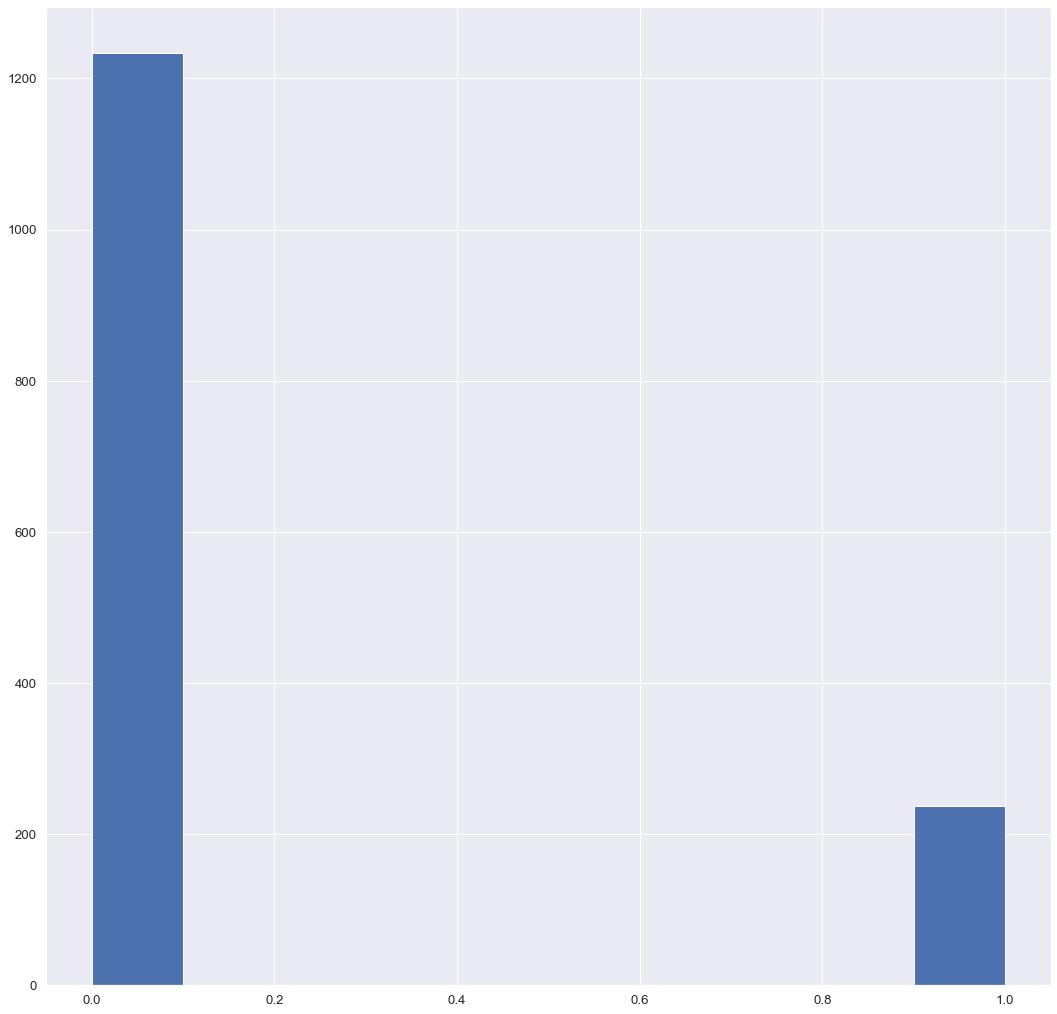

In [43]:
df.Attrition.hist()

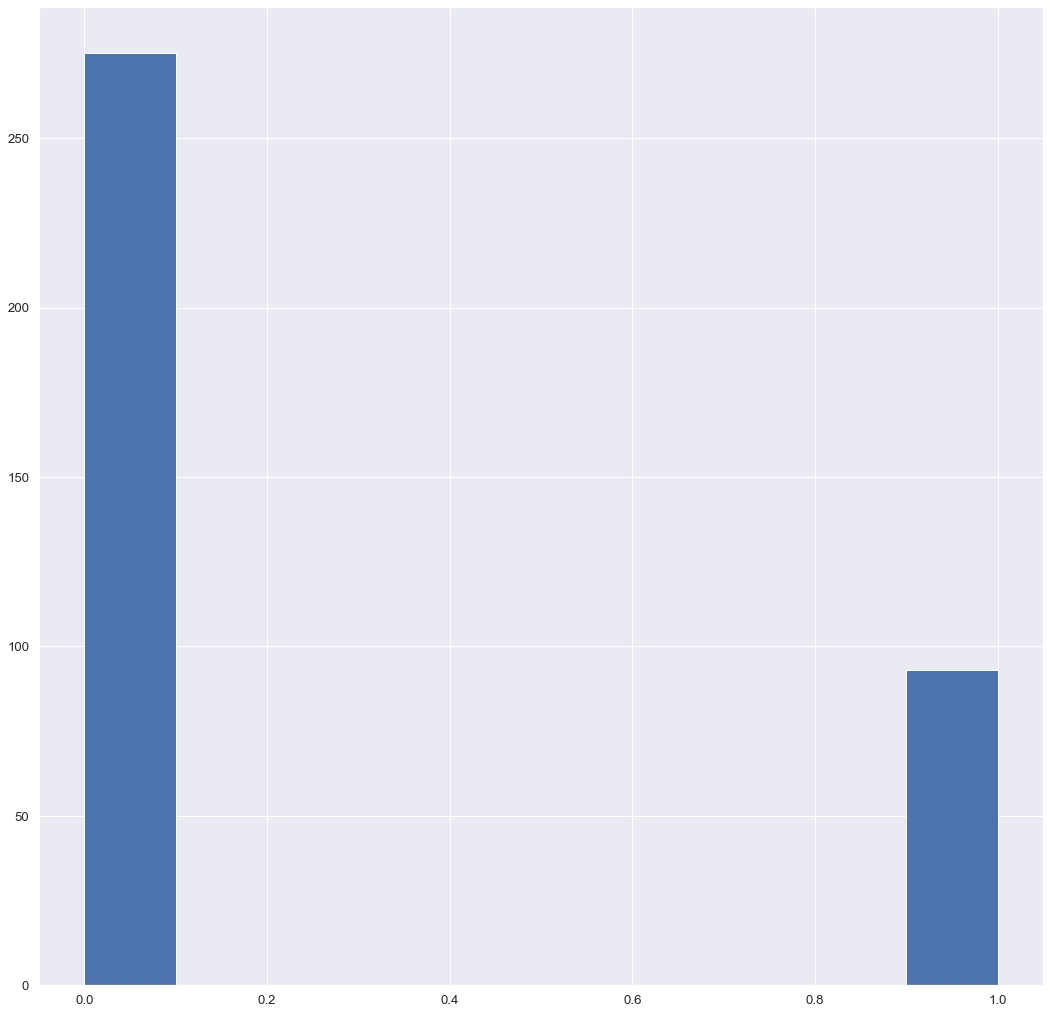

In [44]:
threshold = .1
y_pred = np.where(model_lr_sm.predict(X_test_lr) < threshold, 1, 0)

pd.Series(y_pred).hist()

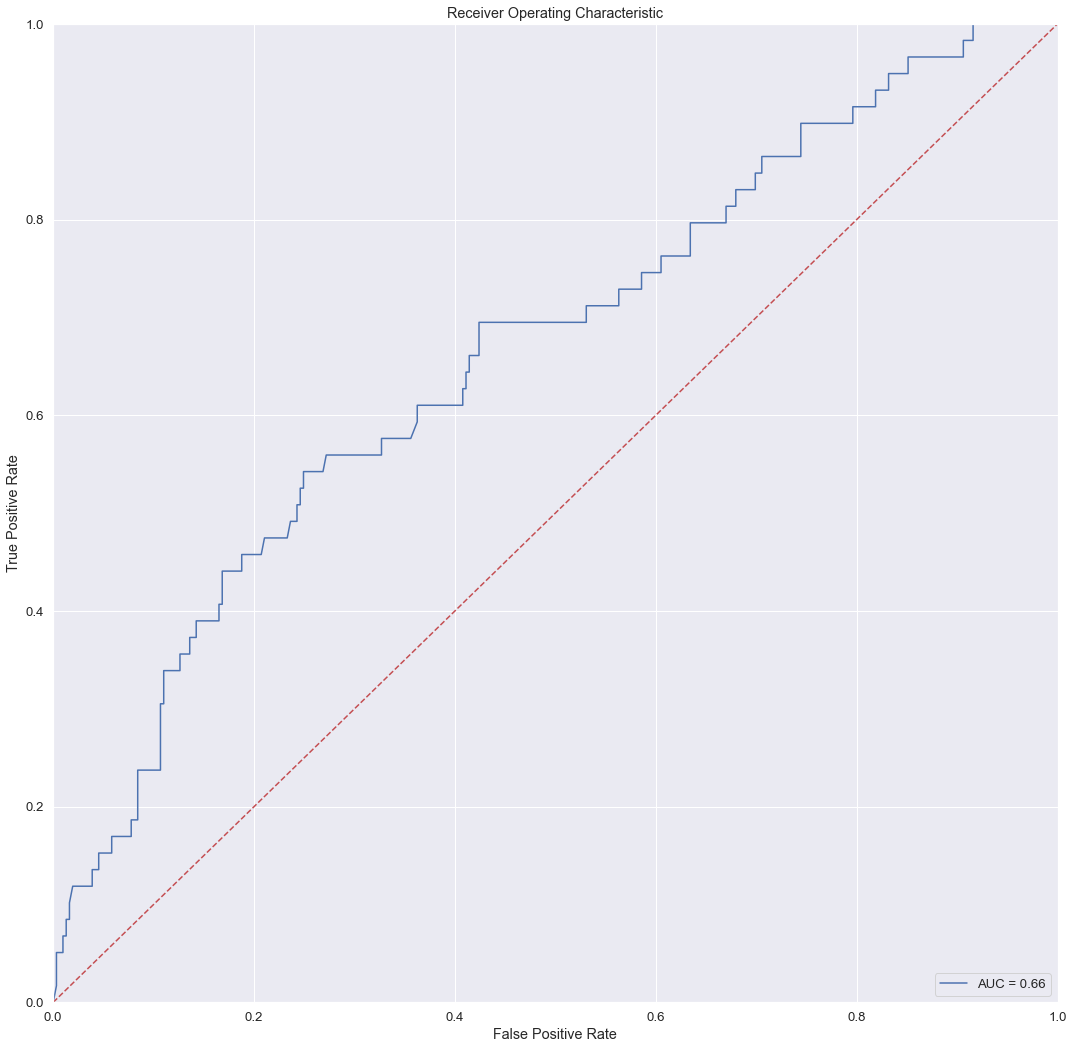

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,model_lr_sm.predict(X_test_lr))
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

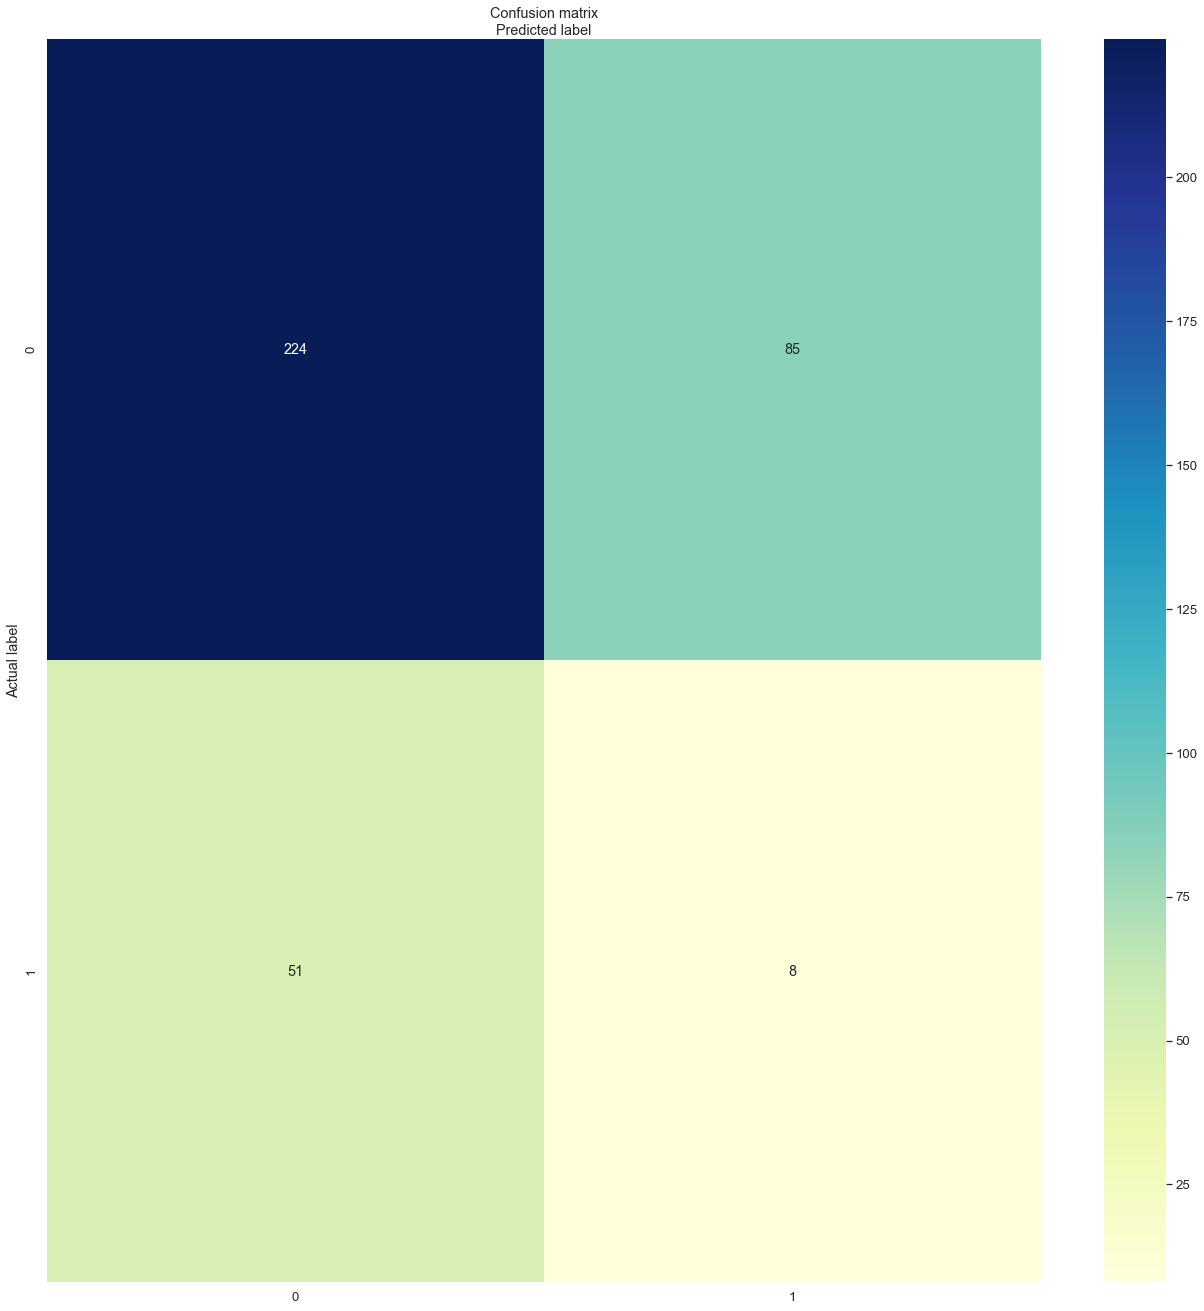

In [46]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
# instantiate the model (using the default parameters)
model_lr = LogisticRegression()

# fit the model with data
model_lr.fit(X_train_lr, y_train)

# generate test predictions with the model
y_prob = model_lr.predict_proba(X_test_lr)[:, 0]

threshold = .9
y_pred = np.where(y_prob > threshold, 1, 0)

In [48]:
acc_lr = round(model_lr.score(X_test_lr, y_test)*100, 2)
print(str(acc_lr) + ' percent')

83.97 percent


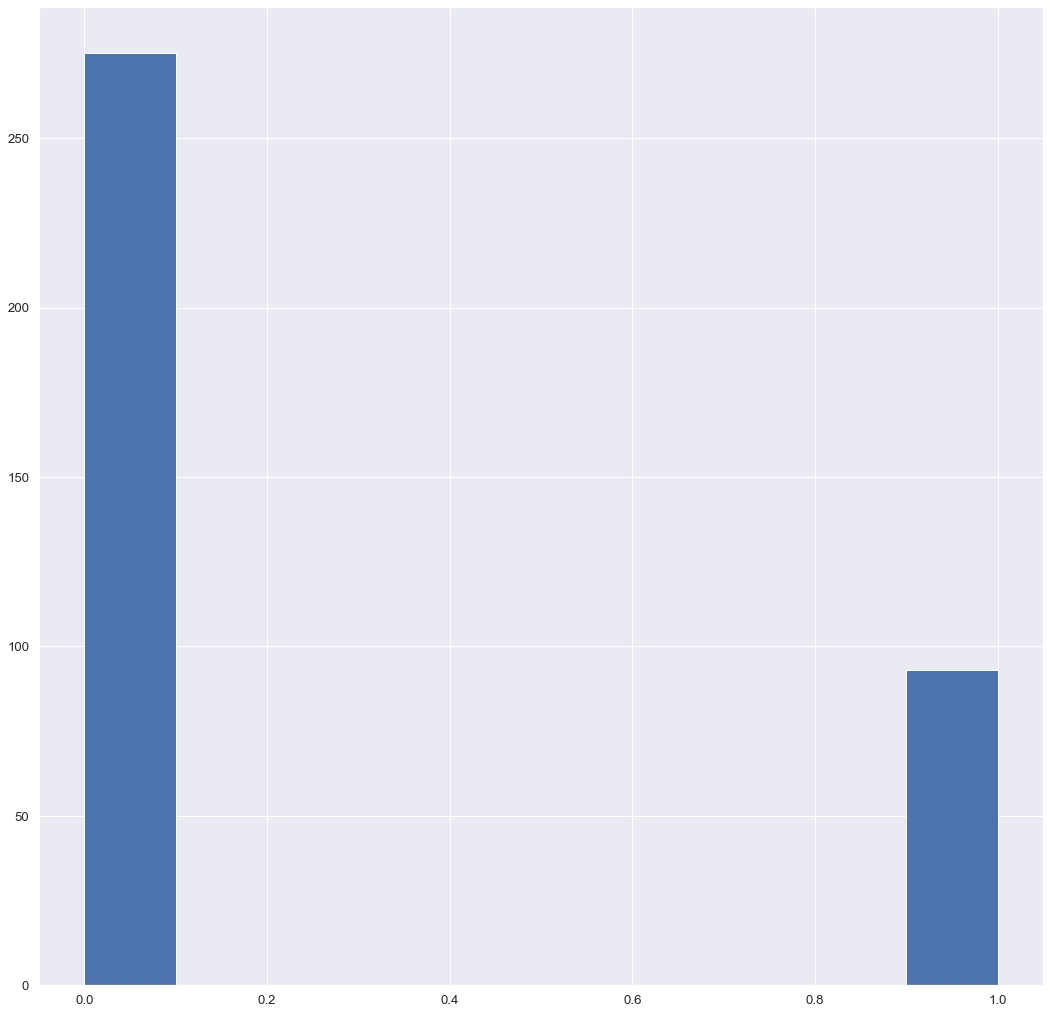

In [49]:
pd.Series(y_pred).hist()

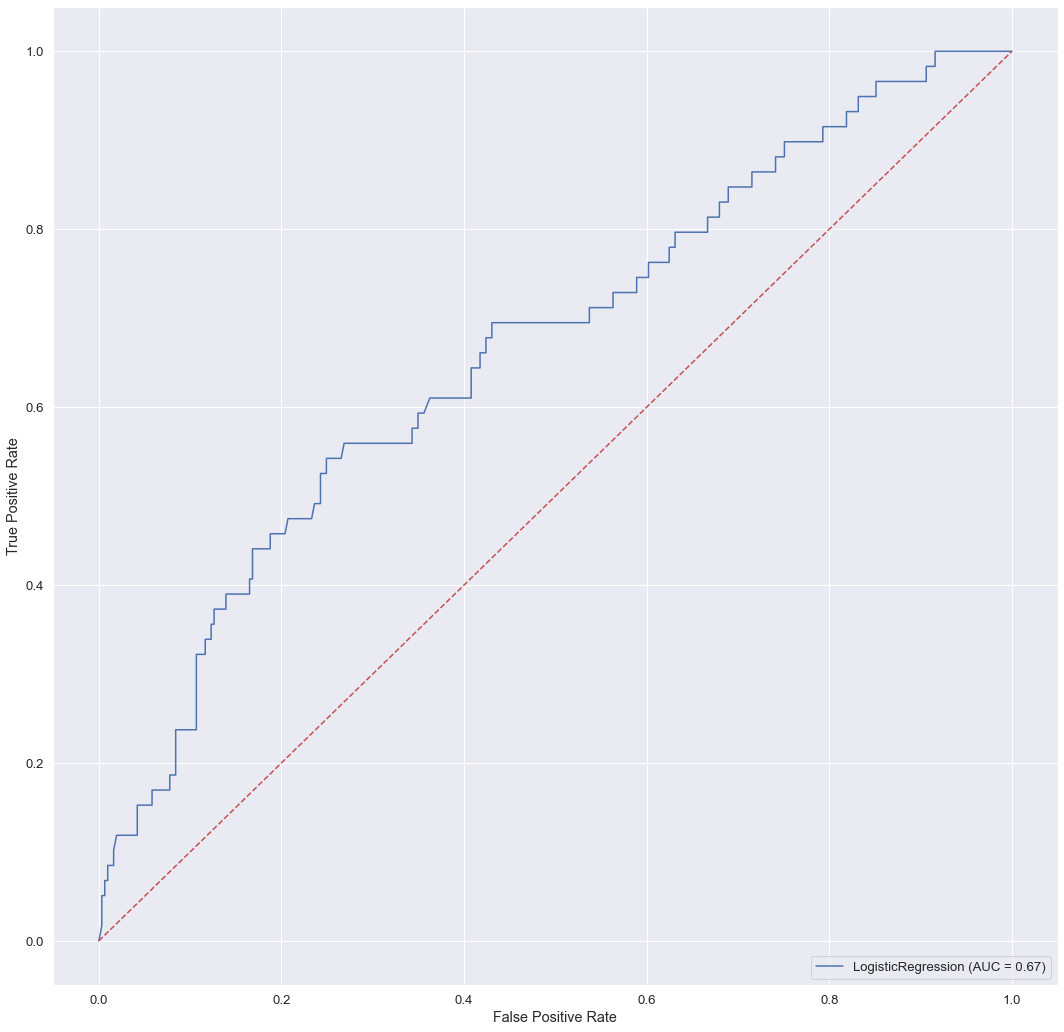

In [50]:
metrics.plot_roc_curve(model_lr, X_test_lr, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

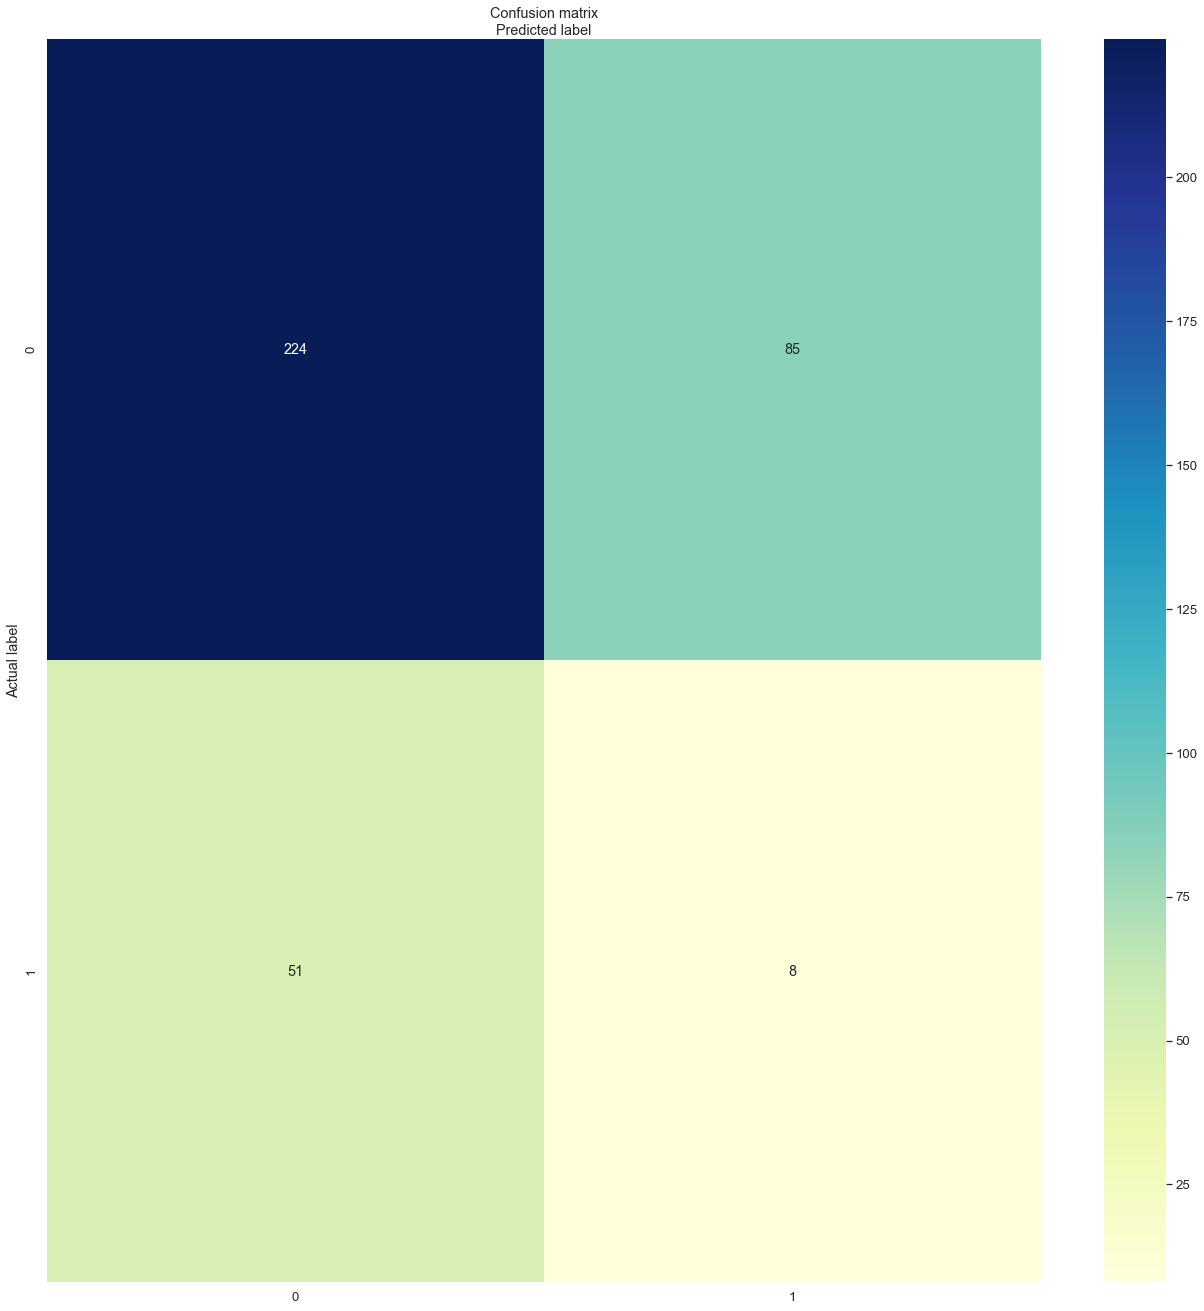

In [51]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Step 6: Non-linear classification models

# Bootstrap Aggregation (Bagging)

In [86]:
bag = BaggingClassifier()

bag.fit(X_train_no_att, y_train)

BaggingClassifier()

In [87]:
bag_y = bag.predict(X_test_no_att)

In [82]:
X_test_no_att = X_test.drop(['Attrition'], axis=1)

In [85]:
X_train_no_att = X_train.drop(['Attrition'], axis = 1)

In [88]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(bag, X_test_no_att, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.833 (0.038)


## Step 7: Graph analysis (???)